# Marginal Costs

This tutorial covers marginal cost modeling and locational marginal prices (LMPs) in PyPSA-GB.

## What You'll Learn

- Understanding marginal costs
- Locational marginal prices (LMPs)
- Price formation in the LOPF
- Network congestion and price spreads
- Generator revenue analysis

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

colors = {
    'CCGT': '#FF6B35', 'nuclear': '#E91E63', 'coal': '#424242',
    'wind_onshore': '#3B6182', 'wind_offshore': '#6BAED6', 'solar_pv': '#FFBB00',
    'biomass': '#4CAF50', 'OCGT': '#FF9800'
}

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Understanding Marginal Costs

### What is Marginal Cost?

The **marginal cost** is the cost of producing one additional MWh of electricity. It includes:
- Fuel costs
- Carbon costs (CO₂ price × emission factor / efficiency)
- Variable O&M costs

For renewables, marginal cost is typically zero (no fuel cost).

## 3. Load a Solved Network

In [2]:
# Load network
n = pypsa.Network("../../../resources/network/EE50_clustered_solved.nc")

print(f"Network loaded")
print(f"  Buses: {len(n.buses)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Snapshots: {len(n.snapshots)}")

INFO:pypsa.network.io:Imported network 'EE50_clustered (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Buses: 110
  Generators: 5235
  Snapshots: 168


## 4. Generator Marginal Costs

In [3]:
# Marginal costs by technology
mc_by_carrier = n.generators.groupby('carrier')['marginal_cost'].mean().sort_values()

# Filter out very high values (load shedding)
mc_by_carrier = mc_by_carrier[mc_by_carrier < 1000]

print("Average Marginal Cost by Technology (£/MWh):")
for carrier, mc in mc_by_carrier.items():
    print(f"  {carrier}: £{mc:.2f}")

Average Marginal Cost by Technology (£/MWh):
  CHP: £0.00
  marine: £0.00
  gas_engine: £0.00
  wind_onshore: £1.44
  wind_offshore: £1.44
  solar_pv: £4.58
  large_hydro: £7.04
  geothermal: £12.46
  nuclear: £18.04
  EU_import: £25.80
  waste_to_energy: £75.60
  landfill_gas: £94.80
  sewage_gas: £103.80
  biomass: £110.40
  advanced_biofuel: £119.40
  biogas: £121.80
  OCGT: £152.96
  CCGT: £152.96
  oil: £240.61


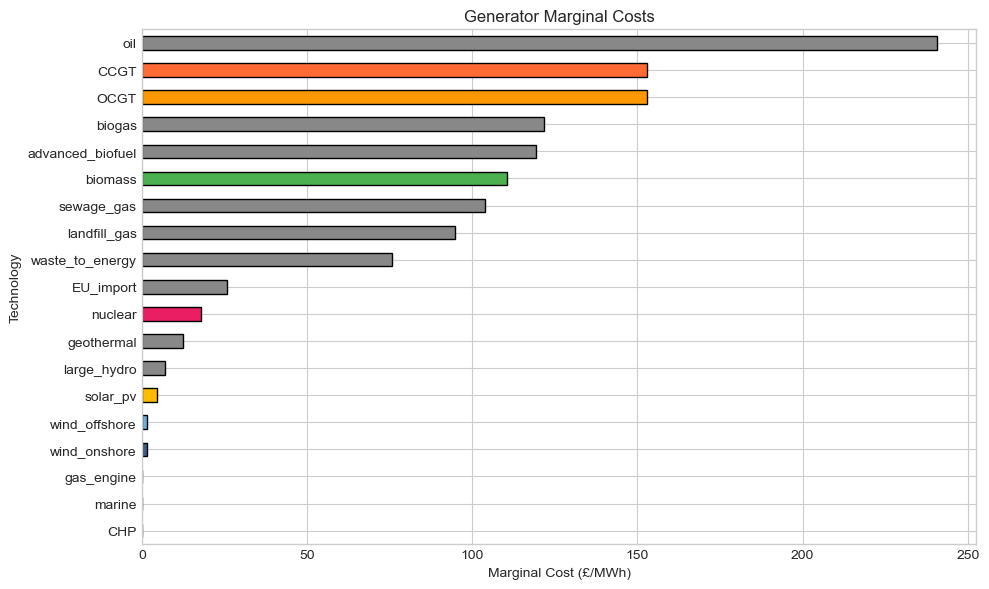

In [4]:
# Marginal cost bar chart
fig, ax = plt.subplots(figsize=(10, 6))

carrier_colors = [colors.get(c, '#888888') for c in mc_by_carrier.index]
mc_by_carrier.plot(kind='barh', ax=ax, color=carrier_colors, edgecolor='black')

ax.set_xlabel('Marginal Cost (£/MWh)')
ax.set_ylabel('Technology')
ax.set_title('Generator Marginal Costs')

plt.tight_layout()
plt.show()

### 4.1 Marginal Cost Components

In [5]:
# Illustrative marginal cost breakdown
# Actual values depend on fuel prices and carbon price

cost_breakdown = pd.DataFrame({
    'Technology': ['CCGT', 'Coal', 'OCGT', 'Nuclear', 'Biomass', 'Wind', 'Solar'],
    'Fuel (£/MWh)': [30, 15, 45, 5, 50, 0, 0],
    'Carbon (£/MWh)': [15, 40, 22, 0, 0, 0, 0],
    'VOM (£/MWh)': [3, 5, 5, 7, 5, 3, 2]
})

cost_breakdown['Total'] = cost_breakdown['Fuel (£/MWh)'] + cost_breakdown['Carbon (£/MWh)'] + cost_breakdown['VOM (£/MWh)']
cost_breakdown = cost_breakdown.set_index('Technology')

print("Illustrative Marginal Cost Breakdown (£/MWh):")
cost_breakdown

Illustrative Marginal Cost Breakdown (£/MWh):


Illustrative Marginal Cost Breakdown (£/MWh):


,Fuel (£/MWh),Carbon (£/MWh),VOM (£/MWh),Total
Technology,,,,
CCGT,30,15,3,48
Coal,15,40,5,60
OCGT,45,22,5,72
Nuclear,5,0,7,12
Biomass,50,0,5,55
Wind,0,0,3,3
Solar,0,0,2,2


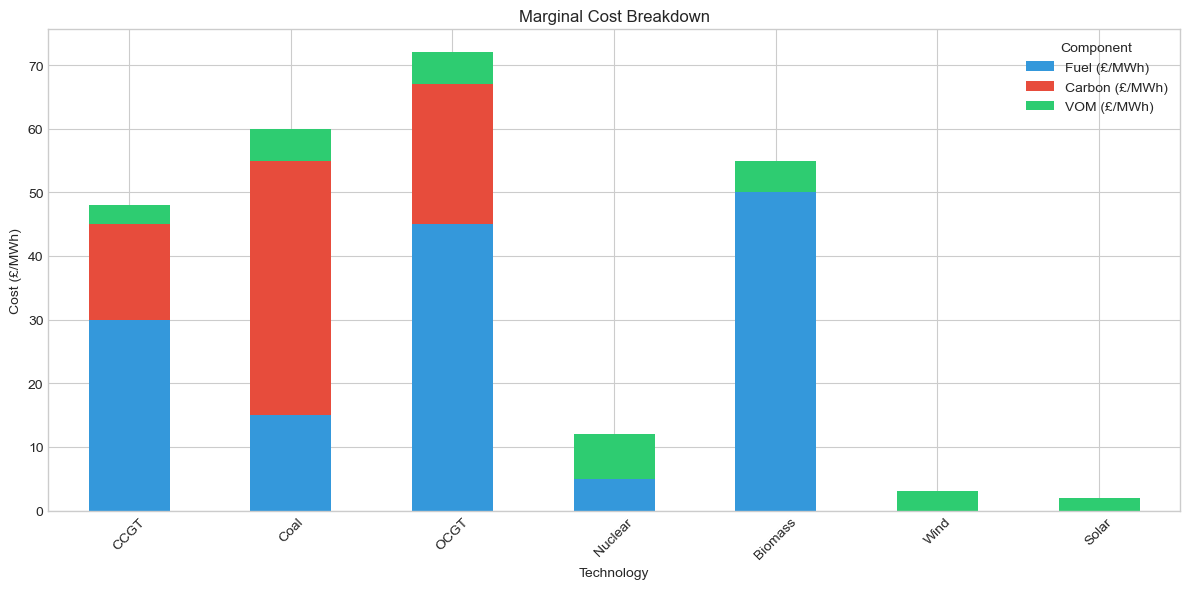

In [6]:
# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

cost_breakdown[['Fuel (£/MWh)', 'Carbon (£/MWh)', 'VOM (£/MWh)']].plot(
    kind='bar', stacked=True, ax=ax,
    color=['#3498db', '#e74c3c', '#2ecc71']
)

ax.set_ylabel('Cost (£/MWh)')
ax.set_xlabel('Technology')
ax.set_title('Marginal Cost Breakdown')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Component')

plt.tight_layout()
plt.show()

## 5. Locational Marginal Prices (LMPs)

### What are LMPs?

LMPs represent the cost of serving one additional MW of demand at each bus. They are:
- The shadow price (dual variable) from the power balance constraint
- Equal to the marginal generator's cost when there's no congestion
- Different across buses when transmission lines are constrained

In [7]:
# Check if marginal prices are available
if 'marginal_price' in n.buses_t:
    lmps = n.buses_t.marginal_price
    
    print("LMP Statistics (£/MWh):")
    print(f"  Mean: £{lmps.mean().mean():.2f}")
    print(f"  Min: £{lmps.min().min():.2f}")
    print(f"  Max: £{lmps.max().max():.2f}")
    print(f"  Std Dev (across buses): £{lmps.std().mean():.2f}")
else:
    print("Marginal prices not available - solve with keep_shadowprices=True")
    lmps = None

LMP Statistics (£/MWh):
  Mean: £15.25
  Min: £-105.08
  Max: £165.93
  Std Dev (across buses): £11.11


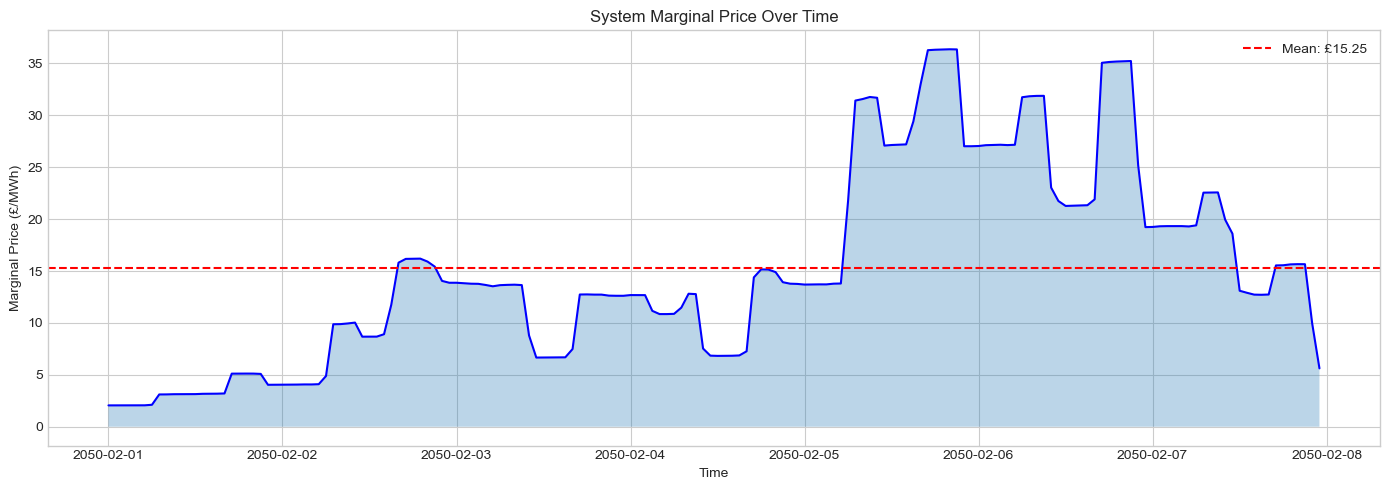

In [8]:
# System average price time series
if lmps is not None:
    system_price = lmps.mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(system_price.index, system_price.values, linewidth=1.5, color='blue')
    ax.fill_between(system_price.index, system_price.values, alpha=0.3)
    
    ax.axhline(y=system_price.mean(), color='red', linestyle='--', 
              label=f'Mean: £{system_price.mean():.2f}')
    
    ax.set_ylabel('Marginal Price (£/MWh)')
    ax.set_xlabel('Time')
    ax.set_title('System Marginal Price Over Time')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

### 5.1 LMP Variability Across Buses

In [9]:
# Average LMP by bus
if lmps is not None:
    avg_lmp = lmps.mean().sort_values(ascending=False)
    
    print("Top 10 Highest Average LMP Buses:")
    print(avg_lmp.head(10).round(2).to_string())
    
    print(f"\nTop 10 Lowest Average LMP Buses:")
    print(avg_lmp.tail(10).round(2).to_string())

Top 10 Highest Average LMP Buses:
name
cluster_66    53.67
cluster_11    40.16
cluster_27    38.16
cluster_13    38.09
cluster_35    37.15
cluster_93    35.31
cluster_45    33.83
cluster_50    33.83
cluster_65    33.22
cluster_99    31.51

Top 10 Lowest Average LMP Buses:
name
cluster_26     2.49
cluster_71     2.45
cluster_2      2.25
cluster_7      1.88
cluster_73     1.88
cluster_48     1.16
cluster_6      0.92
cluster_62     0.61
cluster_49     0.57
cluster_90   -30.55


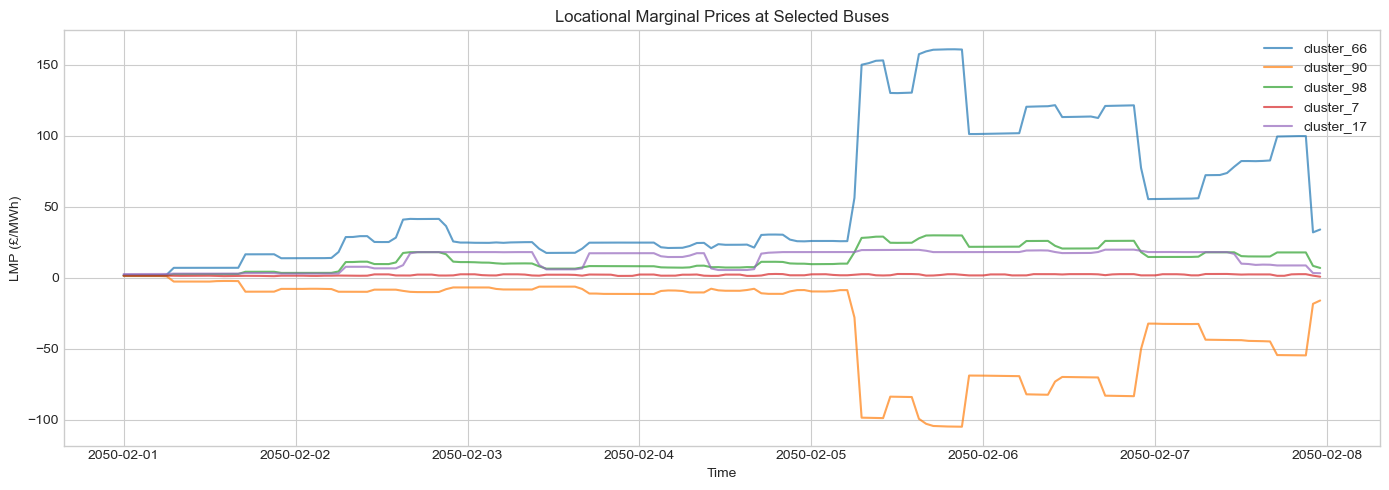

In [10]:
# Plot LMPs for selected buses
if lmps is not None and len(lmps.columns) > 3:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Select a few representative buses
    sample_buses = [avg_lmp.idxmax(), avg_lmp.idxmin()] + list(avg_lmp.sample(3).index)
    
    for bus in sample_buses[:5]:
        ax.plot(lmps.index, lmps[bus], linewidth=1.5, label=bus, alpha=0.7)
    
    ax.set_ylabel('LMP (£/MWh)')
    ax.set_xlabel('Time')
    ax.set_title('Locational Marginal Prices at Selected Buses')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

### 5.2 Price Spread (Congestion Indicator)

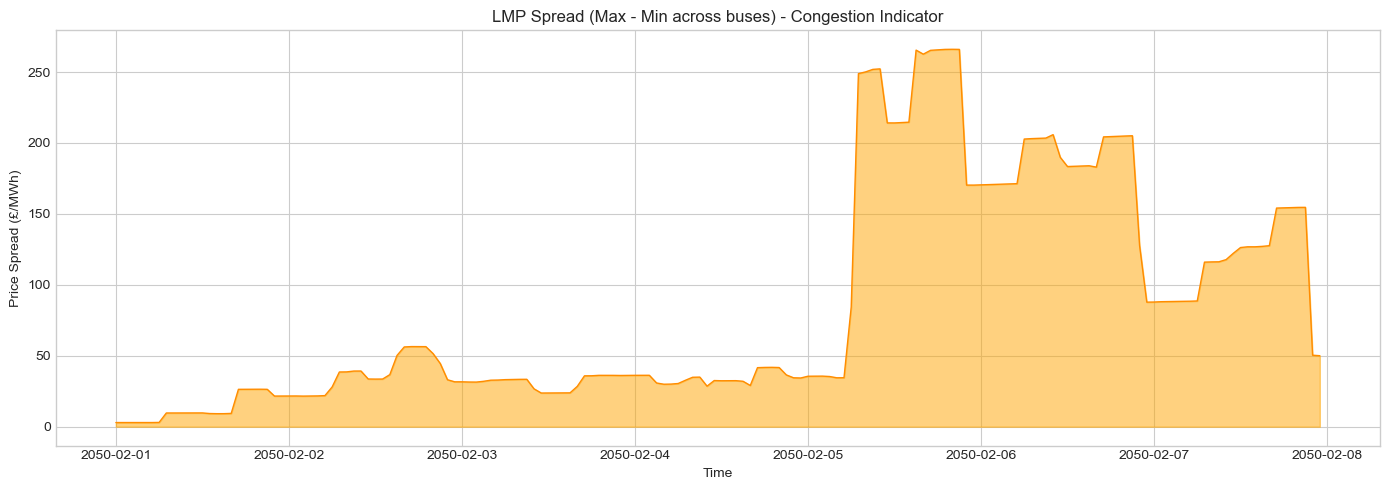

Price Spread Statistics:
  Mean: £84.60
  Max: £266.02
  Hours with spread > £10: 151


In [11]:
# Price spread between buses
if lmps is not None:
    price_spread = lmps.max(axis=1) - lmps.min(axis=1)
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.fill_between(price_spread.index, price_spread.values, alpha=0.5, color='orange')
    ax.plot(price_spread.index, price_spread.values, color='darkorange', linewidth=1)
    
    ax.set_ylabel('Price Spread (£/MWh)')
    ax.set_xlabel('Time')
    ax.set_title('LMP Spread (Max - Min across buses) - Congestion Indicator')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Price Spread Statistics:")
    print(f"  Mean: £{price_spread.mean():.2f}")
    print(f"  Max: £{price_spread.max():.2f}")
    print(f"  Hours with spread > £10: {(price_spread > 10).sum()}")

## 6. Price Duration Curve

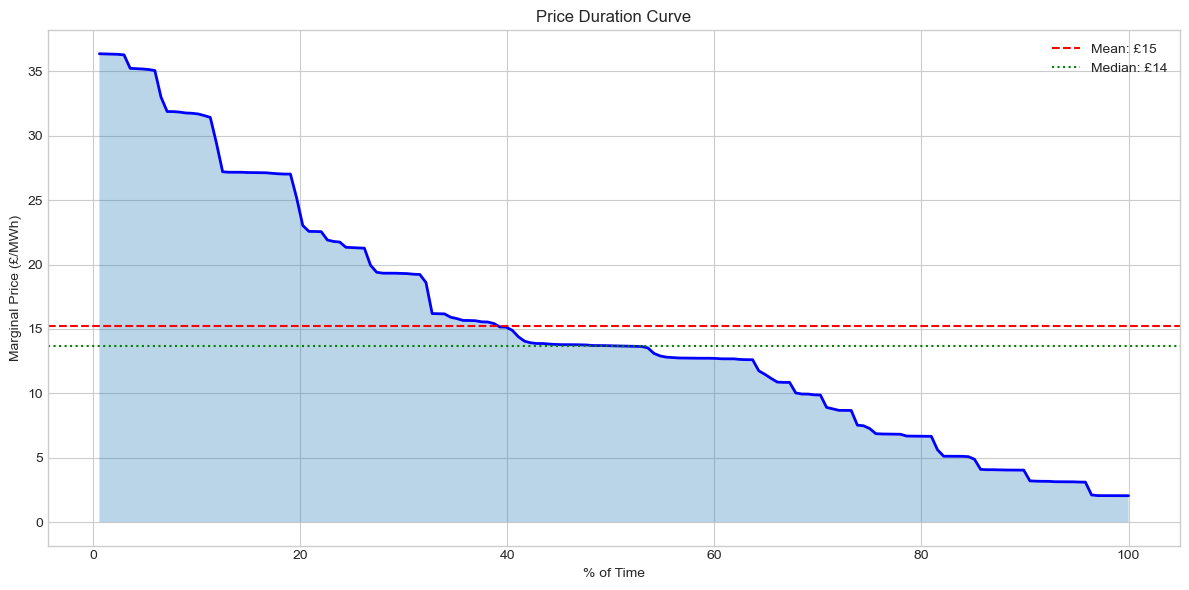

In [12]:
if lmps is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sorted_prices = system_price.sort_values(ascending=False).values
    hours = np.arange(1, len(sorted_prices) + 1)
    hours_pct = hours / len(hours) * 100
    
    ax.plot(hours_pct, sorted_prices, linewidth=2, color='blue')
    ax.fill_between(hours_pct, sorted_prices, alpha=0.3)
    
    # Reference lines
    ax.axhline(y=system_price.mean(), color='red', linestyle='--', 
              label=f'Mean: £{system_price.mean():.0f}')
    ax.axhline(y=system_price.median(), color='green', linestyle=':', 
              label=f'Median: £{system_price.median():.0f}')
    
    ax.set_xlabel('% of Time')
    ax.set_ylabel('Marginal Price (£/MWh)')
    ax.set_title('Price Duration Curve')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 7. Price vs Generation Mix

Correlation: -0.847


Correlation: -0.847


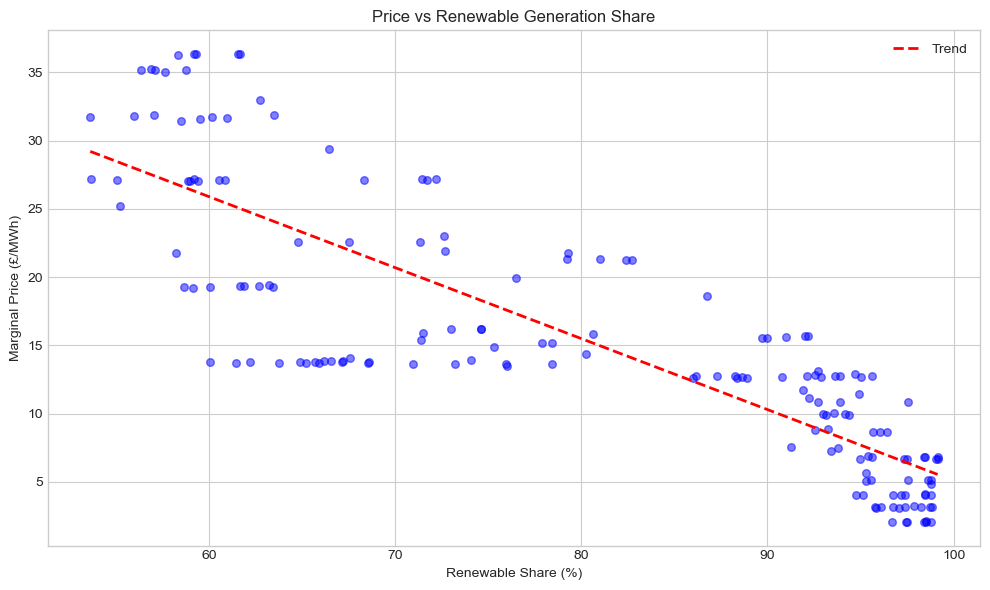

In [13]:
# Calculate renewable share
generation = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
renewable_carriers = ['wind_onshore', 'wind_offshore', 'solar_pv']
renewable_gen = generation[[c for c in renewable_carriers if c in generation.columns]].sum(axis=1)
total_gen = generation.sum(axis=1)
renewable_share = renewable_gen / total_gen * 100

if lmps is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    scatter = ax.scatter(renewable_share, system_price, alpha=0.5, c='blue', s=30)
    
    # Trend line
    z = np.polyfit(renewable_share, system_price, 1)
    p = np.poly1d(z)
    x_sorted = renewable_share.sort_values()
    ax.plot(x_sorted, p(x_sorted), 'r--', linewidth=2, label='Trend')
    
    ax.set_xlabel('Renewable Share (%)')
    ax.set_ylabel('Marginal Price (£/MWh)')
    ax.set_title('Price vs Renewable Generation Share')
    ax.legend()
    
    # Correlation
    corr = renewable_share.corr(system_price)
    print(f"Correlation: {corr:.3f}")
    
    plt.tight_layout()
    plt.show()

## 8. Generator Revenue Analysis

In [14]:
# Calculate generator revenue
if lmps is not None:
    # Revenue = generation × LMP at bus
    revenue = pd.DataFrame()
    
    for gen in n.generators.index:
        bus = n.generators.loc[gen, 'bus']
        if bus in lmps.columns and gen in n.generators_t.p.columns:
            gen_output = n.generators_t.p[gen]
            gen_lmp = lmps[bus]
            revenue[gen] = gen_output * gen_lmp
    
    # Total revenue by carrier
    revenue_by_carrier = revenue.sum().groupby(n.generators.carrier).sum() / 1e6  # £M
    
    print("Total Revenue by Technology (£M):")
    print(revenue_by_carrier.sort_values(ascending=False).round(2).to_string())

Total Revenue by Technology (£M):
carrier
wind_offshore       85.48
wind_onshore        30.42
nuclear             26.51
solar_pv            26.16
EU_import           18.47
gas_engine           1.75
large_hydro          0.87
marine               0.70
waste_to_energy      0.51
advanced_biofuel     0.07
landfill_gas         0.06
sewage_gas           0.01
CHP                  0.00
biogas               0.00
CCGT                 0.00
biomass              0.00
OCGT                 0.00
load_shedding        0.00
geothermal           0.00
oil                  0.00


In [15]:
# Revenue per MWh (average price received)
if lmps is not None:
    gen_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()
    revenue_total = revenue.sum().groupby(n.generators.carrier).sum()
    
    avg_price_received = revenue_total / gen_by_carrier
    avg_price_received = avg_price_received.dropna().sort_values(ascending=False)
    
    print("Average Price Received (£/MWh):")
    for carrier, price in avg_price_received.items():
        print(f"  {carrier}: £{price:.2f}")
    
    print(f"\nSystem average price: £{system_price.mean():.2f}")

Average Price Received (£/MWh):
  advanced_biofuel: £118.61
  sewage_gas: £101.92
  landfill_gas: £98.37
  waste_to_energy: £87.78
  nuclear: £26.28
  CCGT: £25.29
  large_hydro: £19.96
  EU_import: £18.78
  load_shedding: £16.98
  solar_pv: £16.49
  OCGT: £14.47
  gas_engine: £13.89
  wind_onshore: £13.64
  biogas: £12.04
  wind_offshore: £10.66
  biomass: £10.63
  CHP: £2.53
  geothermal: £2.48
  oil: £2.45
  marine: £2.20

System average price: £15.25
